In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch
from highlight_text import ax_text, fig_text
from collections import Counter

from highlight_text import ax_text
from PIL import Image
from mplsoccer import add_image
import matplotlib.ticker as ticker
import urllib
from urllib.request import urlopen

from sklearn.cluster import KMeans
import matplotlib.patches as patches

pd.set_option('display.max_columns', None)

In [2]:
%%time
df = pd.read_csv("D:\FData\LaLiga_2023-24\GW1_to_GW_38combinded.csv")

CPU times: total: 3.42 s
Wall time: 3.44 s


# For

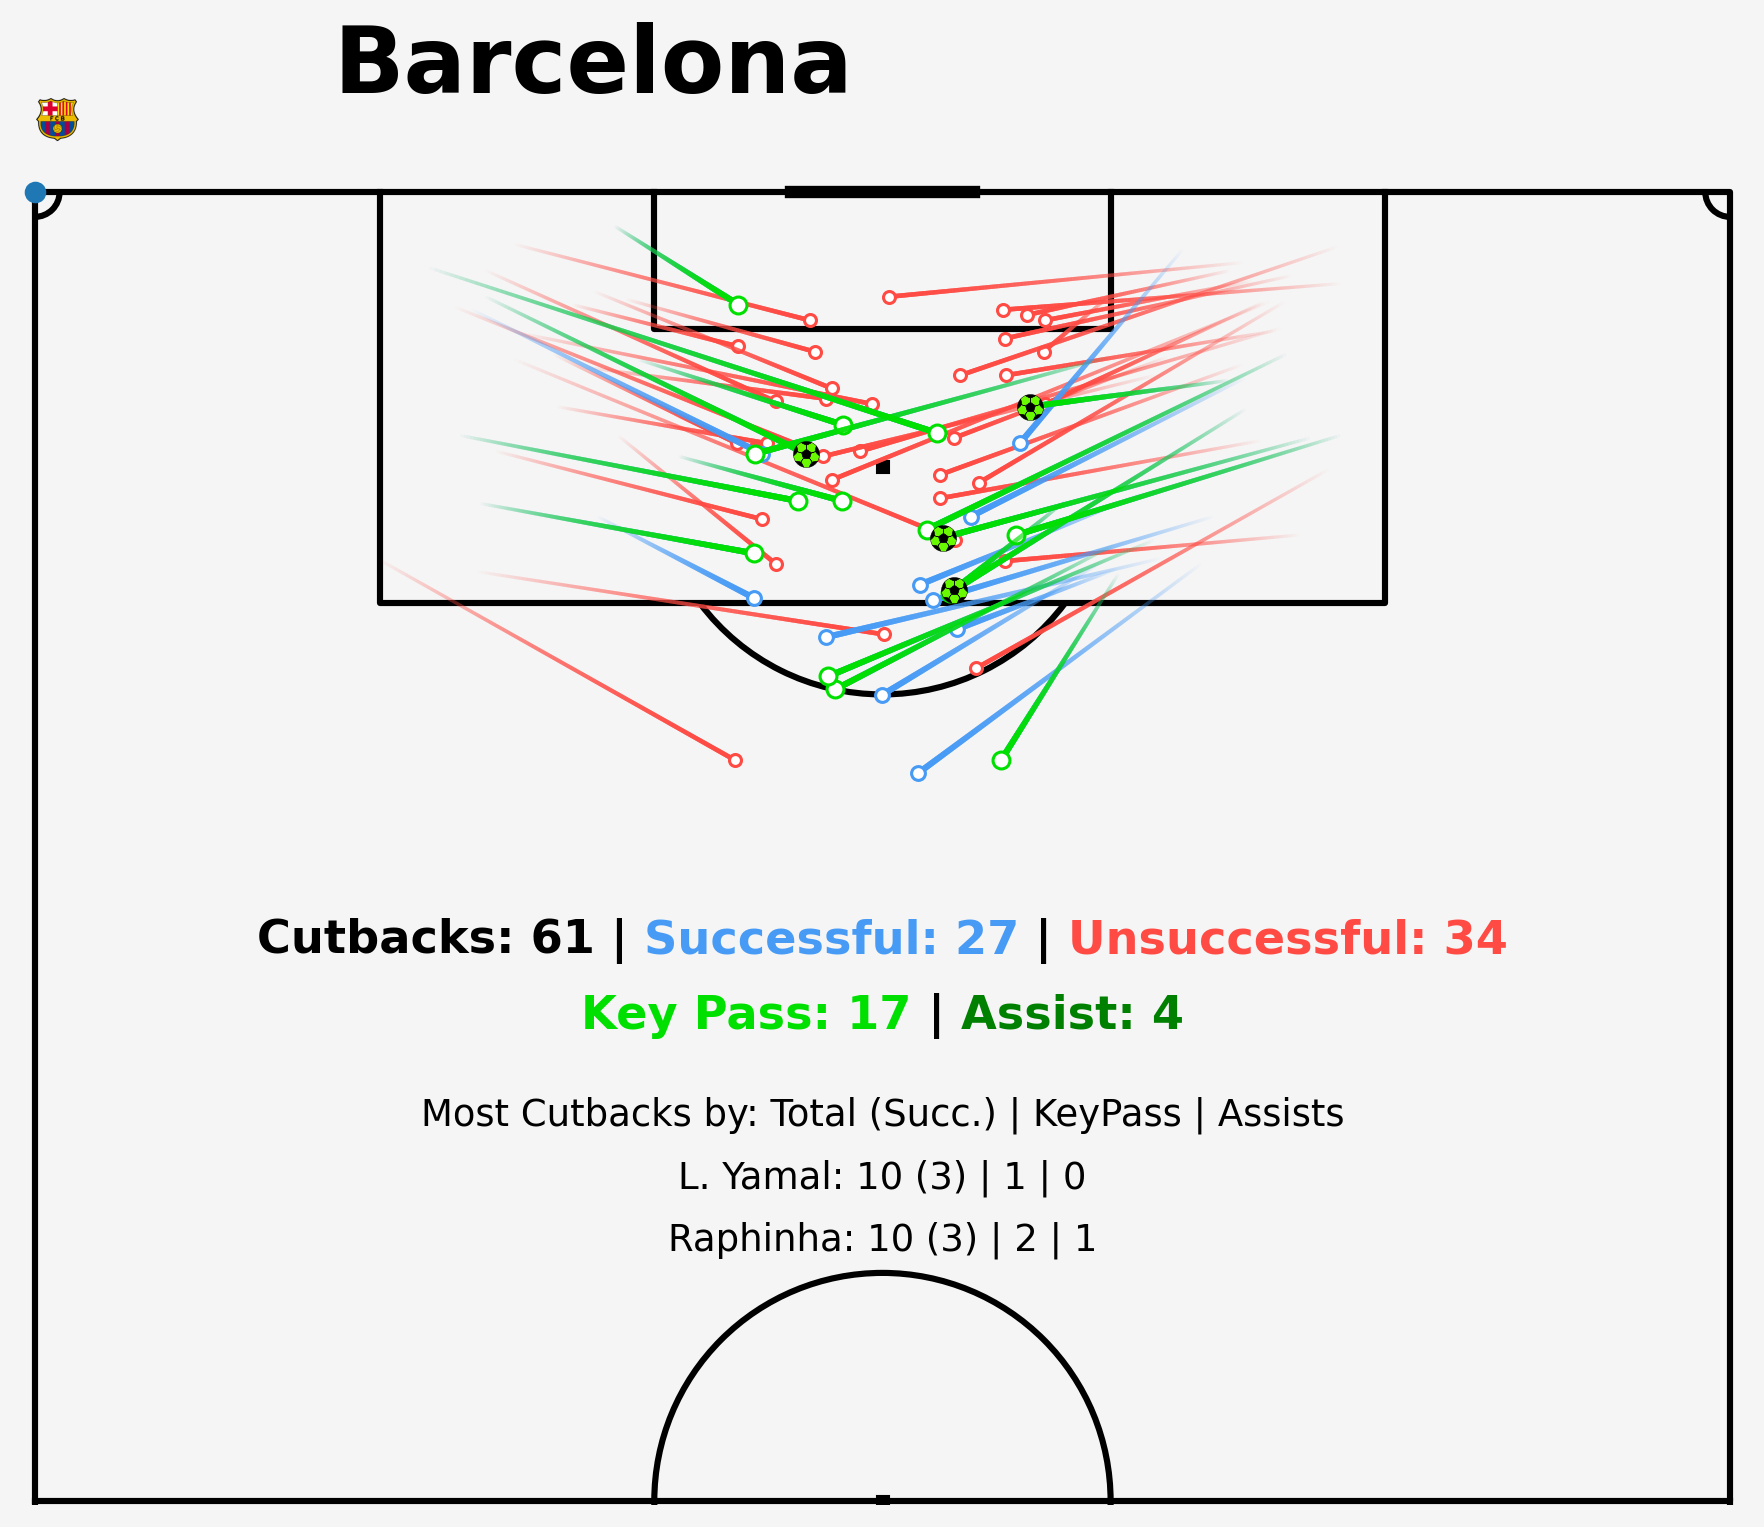

Execution Time: 1.2749888896942139 seconds


In [5]:
# Define the plot_cutback function
def plot_cutback(ax, team_name):
    df_team = df[(df['teamName'] == team_name) & (df['type'] == 'Pass') & (~df['qualifiers'].str.contains('Chipped')) 
                 & (~df['qualifiers'].str.contains('Corner'))]

    # Define the conditions for the half_spaces area
    half_space_cond = ((df_team['x'] >= 88.54) & (df_team['x'] <= 105) & 
                       ((df_team['y'] >= 40.8) & (df_team['y'] <= 54.4) | (df_team['y'] >= 13.6) & (df_team['y'] <= 27.2)) & 
                       (df_team['endY'] >= 27.2) & (df_team['endY'] <= 40.8) & (df_team['endX'] >= 81.67))

    cutback = df_team[half_space_cond]

    pitch = VerticalPitch(pitch_type='uefa', pitch_color='#f5f5f5', line_color='k', spot_type='square', linewidth=2, half=True, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_ylim(52.35)
    ax.set_xlim(-0.5, 68.5)

    succ_cutbacks = 0
    unsucc_cutbacks = 0
    kp_cutbacks = 0
    assist_cutbacks = 0
    succ_cutbacks = unsucc_cutbacks = kp_cutbacks = assist_cutbacks = 0
    succ_cutbacks_players = []
    unsucc_cutbacks_players = []
    kp_cutbacks_players = []
    assist_cutbacks_players = []

    # Loop through cutbacks and categorize them
    for index, row in cutback.iterrows():
        if row['x'] >= row['endX'] + 1:
            if row['outcomeType'] == 'Successful':
                succ_cutbacks_players.append(row['shortName'])
                pitch.lines(row['x'], row['y'], row['endX'], row['endY'], lw=2, comet=True, transparent=True, zorder=2, color='#479bf5', ax=ax)
                pitch.scatter(row['endX'], row['endY'], marker='o', s=20, c='w', ec='#479bf5', lw=1, ax=ax, zorder=2)
                succ_cutbacks += 1
                if 'KeyPass' in row['qualifiers']:
                    kp_cutbacks_players.append(row['shortName'])
                    pitch.lines(row['x'], row['y'], row['endX'], row['endY'], lw=2, comet=True, transparent=True, zorder=3, color='#00e000', ax=ax)
                    pitch.scatter(row['endX'], row['endY'], marker='o', s=30, c='w', ec='#00e000', lw=1, ax=ax, zorder=3)
                    kp_cutbacks += 1
                if 'IntentionalGoalAssist' in row['qualifiers']:
                    assist_cutbacks_players.append(row['shortName'])
                    pitch.scatter(row['endX'], row['endY'], marker='football', s=75, c='#69f900', ax=ax, linewidths=0.15, zorder=4)
                    assist_cutbacks += 1
            elif row['outcomeType'] == 'Unsuccessful':
                unsucc_cutbacks_players.append(row['shortName'])
                pitch.lines(row['x'], row['y'], row['endX'], row['endY'], lw=1.5, comet=True, transparent=True, zorder=1, color='#ff4b44', ax=ax)
                pitch.scatter(row['endX'], row['endY'], marker='o', s=15, c='w', ec='#ff4b44', lw=1, ax=ax, zorder=1)
                unsucc_cutbacks += 1

    # Count the occurrences of each player
    succ_cutback_counts = Counter(succ_cutbacks_players)
    unsucc_cutback_counts = Counter(unsucc_cutbacks_players)
    kp_cutback_counts = Counter(kp_cutbacks_players)
    assist_cutback_counts = Counter(assist_cutbacks_players)

    # Create a DataFrame for players
    players = set(succ_cutback_counts.keys()).union(set(unsucc_cutback_counts.keys()), set(kp_cutback_counts.keys()), set(assist_cutback_counts.keys()))
    data = [{'Player': player, 'succ': succ_cutback_counts[player], 'unsucc': unsucc_cutback_counts[player], 
             'Key Pass': kp_cutback_counts[player], 'Assist': assist_cutback_counts[player]} for player in players]

    # Ensure necessary keys exist in Counter objects
    players = set(succ_cutback_counts.keys()).union(set(unsucc_cutback_counts.keys()), set(kp_cutback_counts.keys()), set(assist_cutback_counts.keys()))
    data = []
    for player in players:
        data.append({
            'Player': player,
            'succ': succ_cutback_counts.get(player, 0),
            'unsucc': unsucc_cutback_counts.get(player, 0),
            'Key Pass': kp_cutback_counts.get(player, 0),
            'Assist': assist_cutback_counts.get(player, 0)
        })
    cutbacks_df = pd.DataFrame(data).fillna(0)
    cutbacks_df['total'] = cutbacks_df['succ'] + cutbacks_df['unsucc']
    cutbacks_df = cutbacks_df.sort_values(by='total', ascending=False).reset_index(drop=True)

    # Convert counts to integers
    cutbacks_df[['succ', 'unsucc', 'Key Pass', 'Assist']] = cutbacks_df[['succ', 'unsucc', 'Key Pass', 'Assist']].astype(int)

    total_cutbacks = succ_cutbacks + unsucc_cutbacks

    ax_text(34, 75, s=f'Cutbacks: {total_cutbacks} | <Successful: {succ_cutbacks}> | <Unsuccessful: {unsucc_cutbacks}>', 
            color='k', fontsize=15, fontweight='bold', highlight_textprops=[{"color":"#479bf5"}, {"color":"#ff4b44"}],
            va = "center", ha = "center", ax=ax)
    ax_text(34, 72, s=f'<Key Pass: {kp_cutbacks}> | <Assist: {assist_cutbacks}>', 
            color='k', fontsize=15, fontweight='bold', highlight_textprops=[{"color":"#00e000"}, {"color":"g"}],
            va = "center", ha = "center", ax=ax)
    ax.text(34, 68, f'Most Cutbacks by: Total (Succ.) | KeyPass | Assists', 
            color='k', fontsize=12, va = "center", ha = "center")
    ax.text(34, 65.5, f"{cutbacks_df['Player'][0]}: {cutbacks_df['total'][0]} ({cutbacks_df['succ'][0]}) | {cutbacks_df['Key Pass'][0]} | {cutbacks_df['Assist'][0]}",
            color='k', fontsize=12, va = "center", ha = "center")
    ax.text(34, 63, f"{cutbacks_df['Player'][1]}: {cutbacks_df['total'][1]} ({cutbacks_df['succ'][1]}) | {cutbacks_df['Key Pass'][1]} | {cutbacks_df['Assist'][1]}",
            color='k', fontsize=12, va = "center", ha = "center")

    ax.text(12, 109, f'{team_name}', color='k', fontsize=30, fontweight='bold')

    # Take data coordinates and transform them to normalized figure coordinates
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((0,107))
    ax_size = 0.02
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    fotmob_url = f'https://raw.githubusercontent.com/adnaaan433/club_teams_logos/main/{team_name}.png'
    fotmob_url = fotmob_url.replace(' ', '%20')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('off')
    
    return 

# Measure the execution time
start_time = time.time()
fig, ax = plt.subplots(facecolor='#f5f5f5', figsize=(10,10), dpi=222)
plot_cutback(ax, 'Barcelona')
end_time = time.time()
execution_time = end_time - start_time

plt.show()

print(f"Execution Time: {execution_time} seconds")

In [19]:
def plot_blank(ax):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color='#d9d9d9', line_color='#d9d9d9', spot_type='square', linewidth=2, half=True, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_ylim(52.35)
    ax.set_xlim(-0.5, 68.5)

Execution Time: 38.09539747238159 seconds


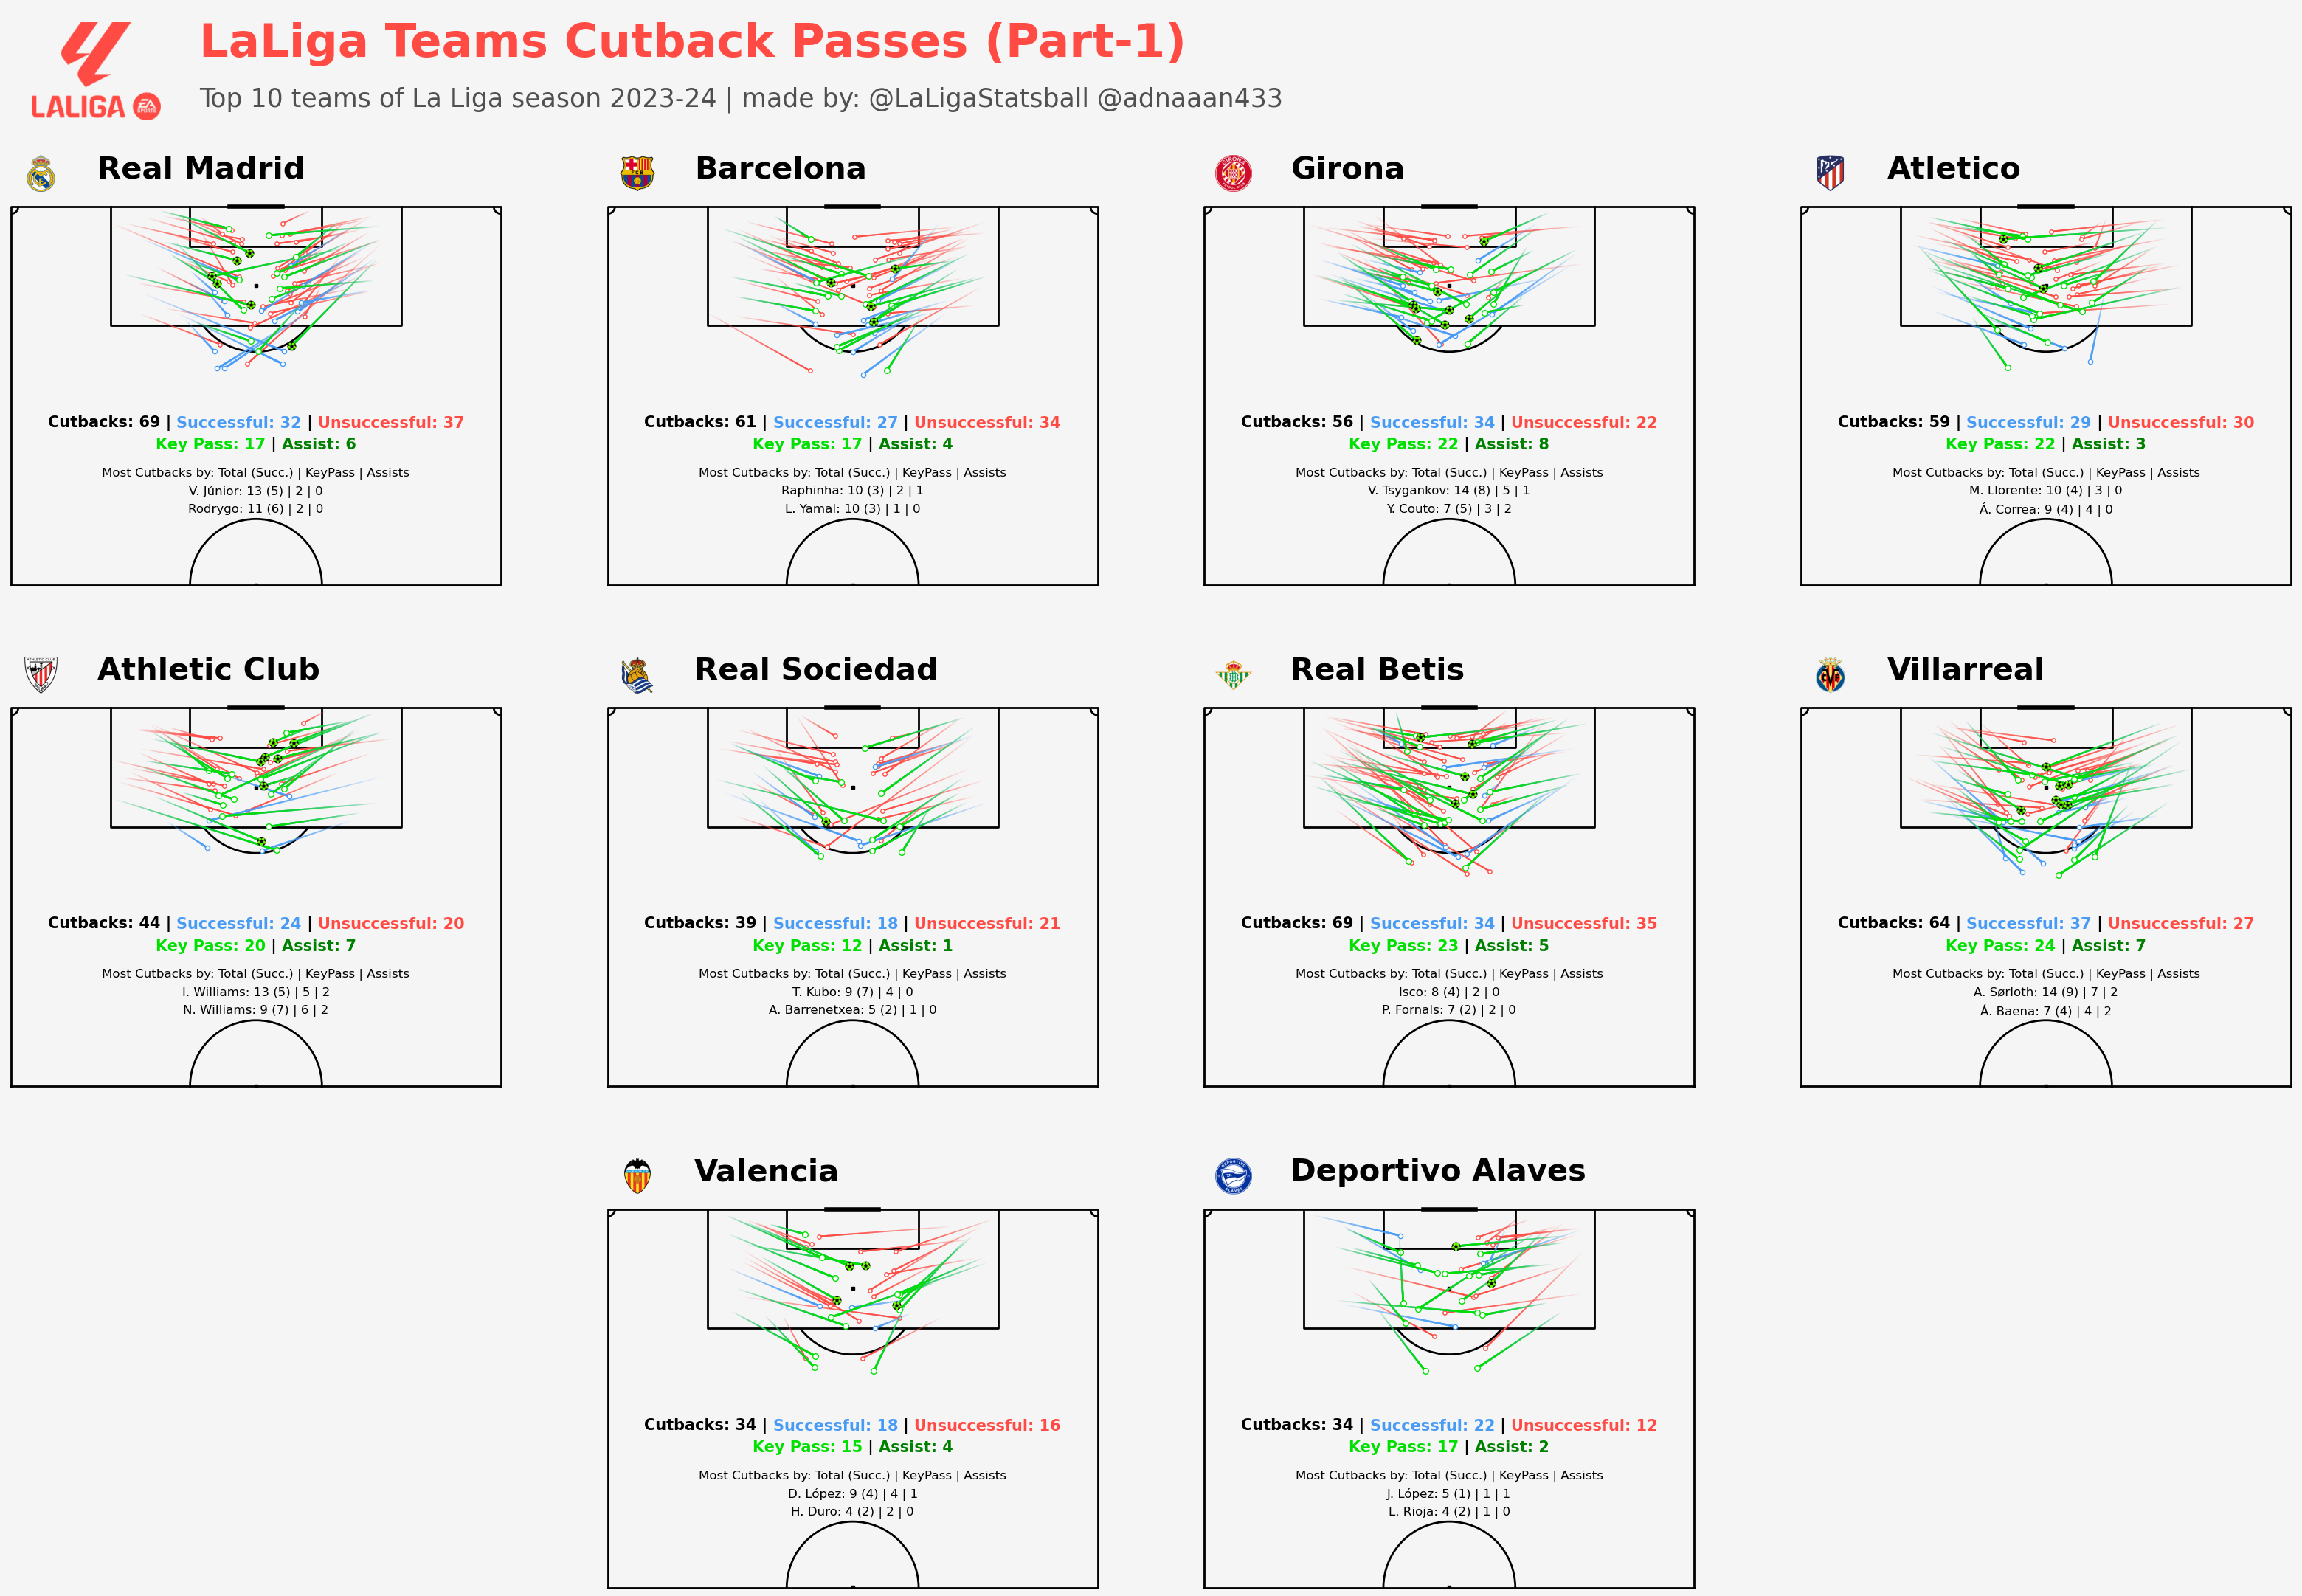

In [40]:
start_time = time.time()
fig, axs = plt.subplots(3, 4, figsize=(40, 25), facecolor='#f5f5f5', dpi=100)
axs = axs.flatten()

# List of team names
team_names = ['Real Madrid', 'Barcelona', 'Girona', 'Atletico', 'Athletic Club', 'Real Sociedad', 'Real Betis', 'Villarreal']

for i, team_name in enumerate(team_names):
    plot_cutback(axs[i], team_name)

plot_blank(axs[8])
plot_cutback(axs[9], 'Valencia')
plot_cutback(axs[10], 'Deportivo Alaves')
plot_blank(axs[11])

fig.text(0.19, 0.95, 'LaLiga Teams Cutback Passes (Part-1)', color='#ff4b44', fontweight='bold', fontsize=45, ha='left', va='center')
fig.text(0.19, 0.92, 'Top 10 teams of La Liga season 2023-24 | made by: @LaLigaStatsball @adnaaan433', color='#505050', fontsize=25, ha='left', va='center')

image_url = 'https://raw.githubusercontent.com/adnaaan433/league_logos/main/LaLiga.png'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.12, bottom=0.90, width=0.07, height=0.07)



# plt.tight_layout()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time} seconds")

Execution Time: 29.96472454071045 seconds


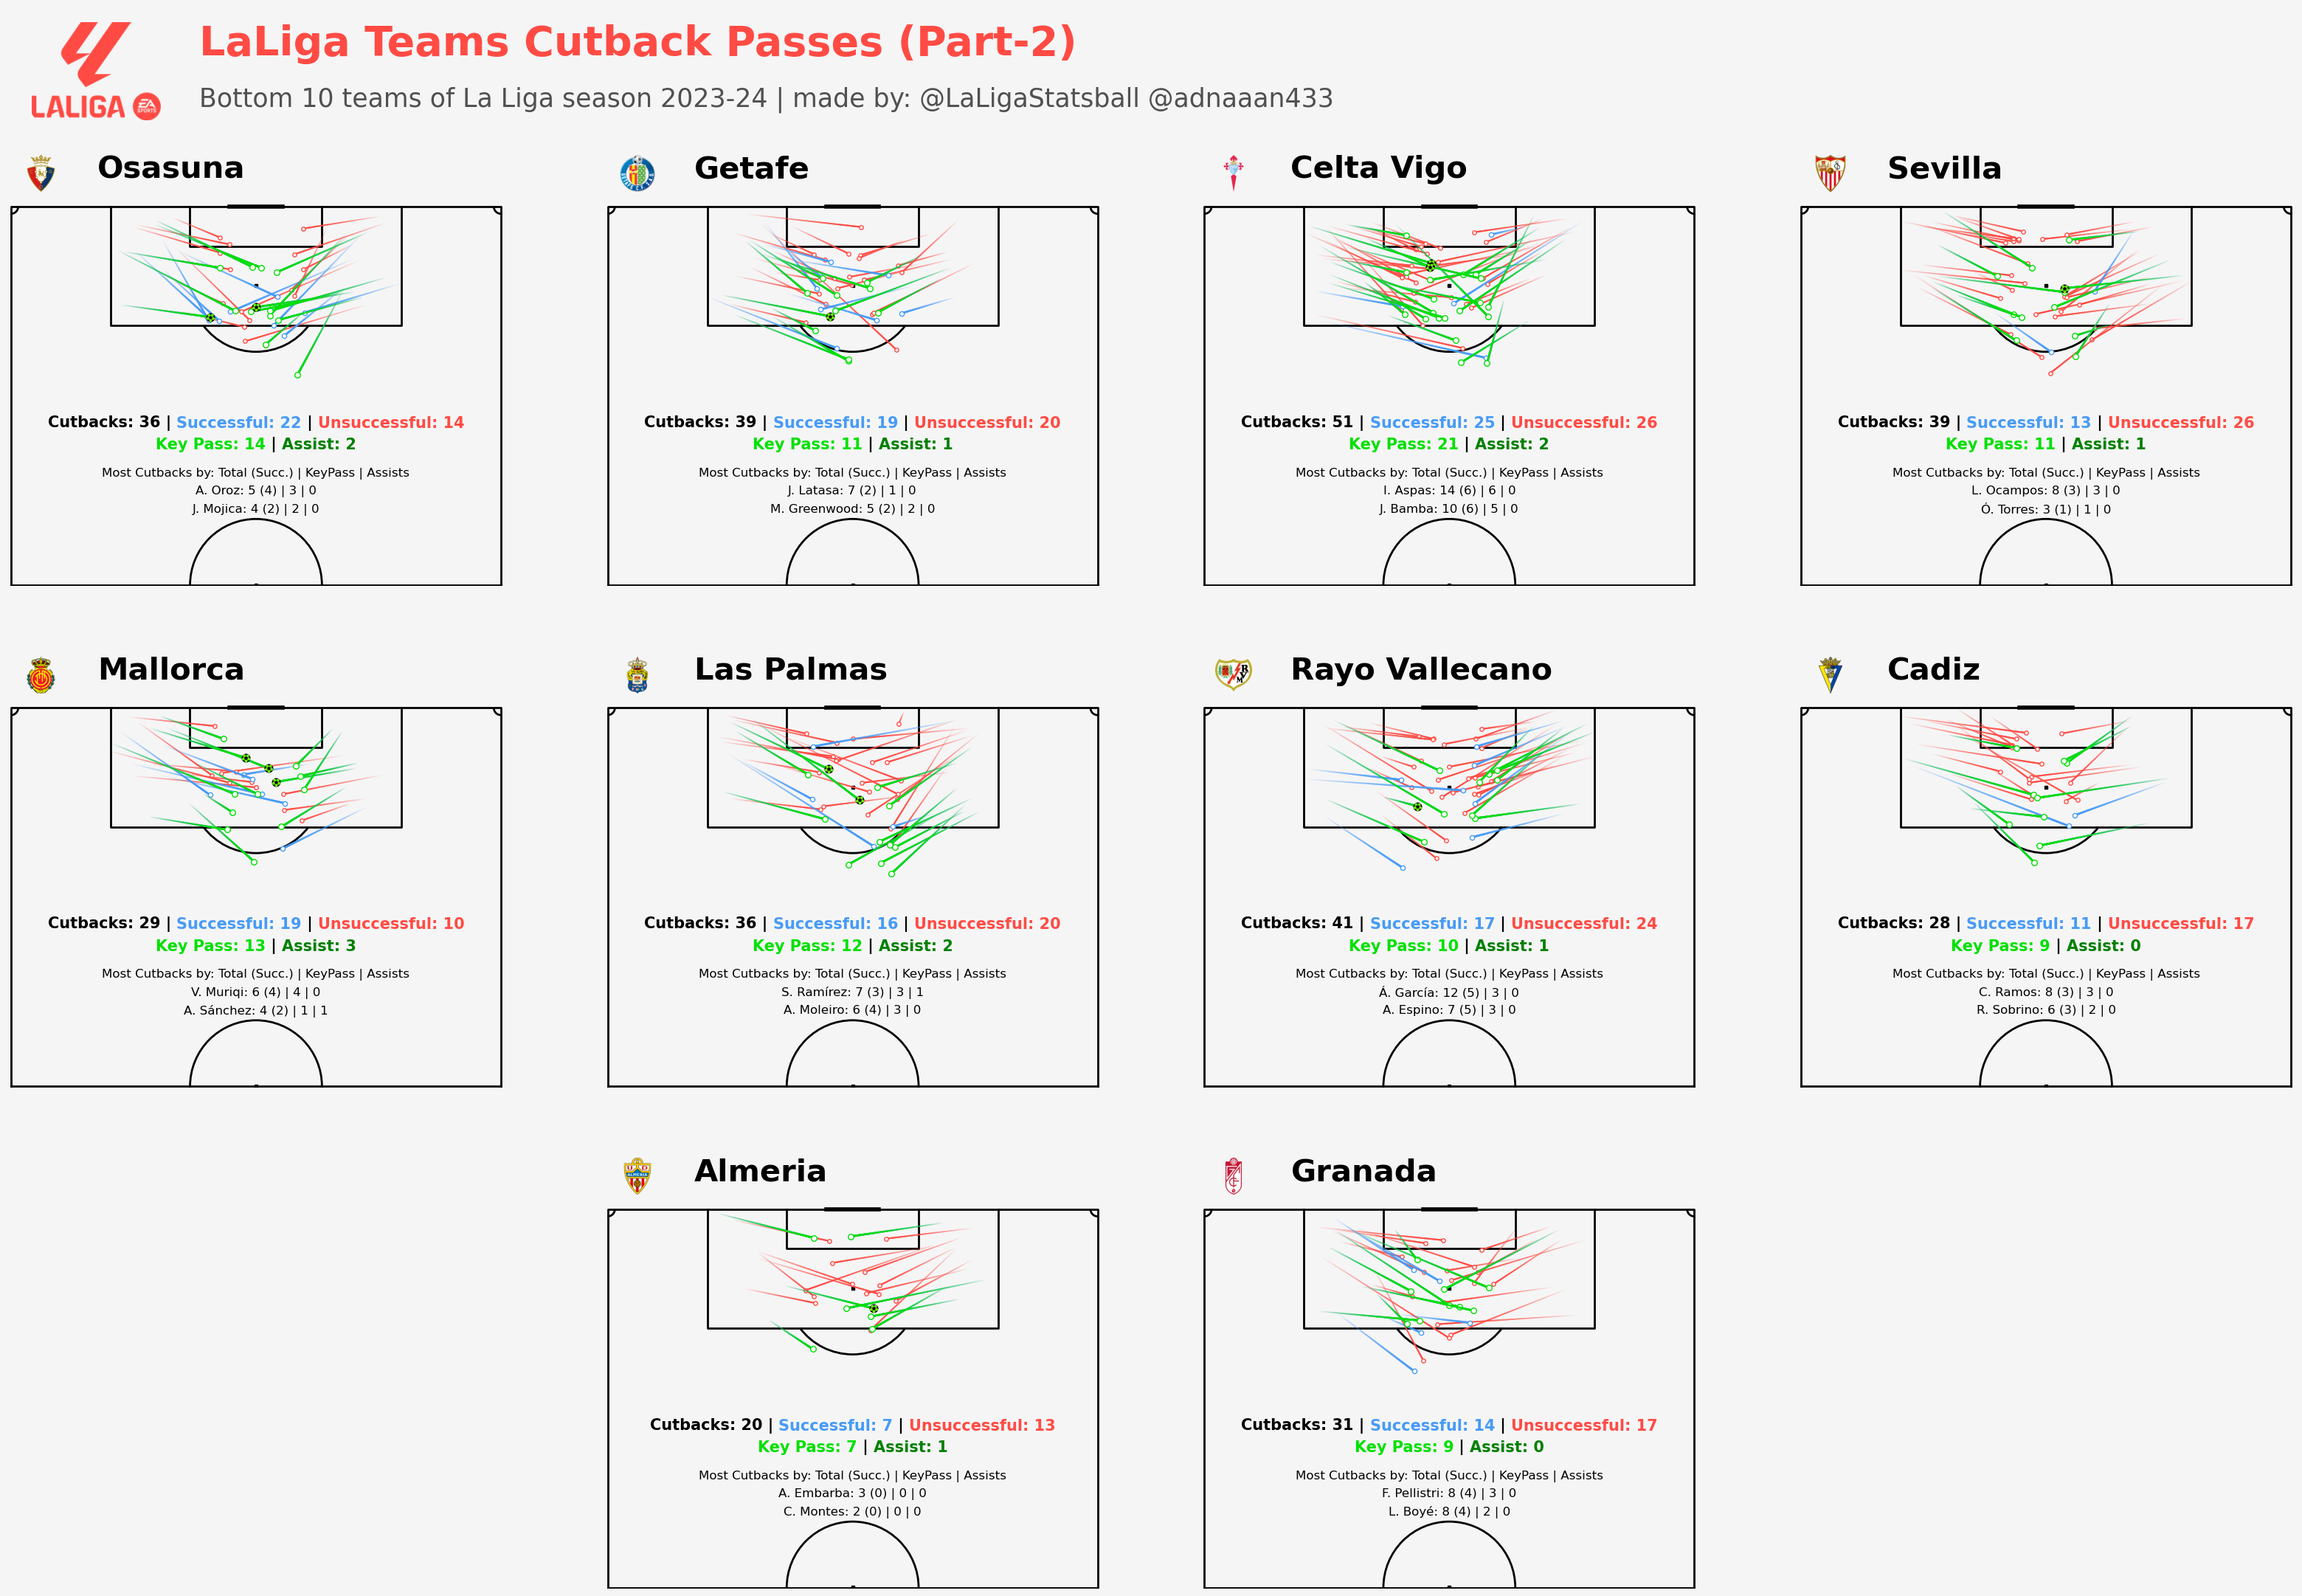

In [41]:
start_time = time.time()
fig, axs = plt.subplots(3, 4, figsize=(40, 25), facecolor='#f5f5f5', dpi=100)
axs = axs.flatten()

# List of team names
team_names = ['Osasuna', 'Getafe', 'Celta Vigo', 'Sevilla', 'Mallorca', 'Las Palmas', 
              'Rayo Vallecano', 'Cadiz']

for i, team_name in enumerate(team_names):
    plot_cutback(axs[i], team_name)

plot_blank(axs[8])
plot_cutback(axs[9], 'Almeria')
plot_cutback(axs[10], 'Granada')
plot_blank(axs[11])

fig.text(0.19, 0.95, 'LaLiga Teams Cutback Passes (Part-2)', color='#ff4b44', fontweight='bold', fontsize=40, ha='left', va='center')
fig.text(0.19, 0.92, 'Bottom 10 teams of La Liga season 2023-24 | made by: @LaLigaStatsball @adnaaan433', color='#505050', fontsize=25, ha='left', va='center')

image_url = 'https://raw.githubusercontent.com/adnaaan433/league_logos/main/LaLiga.png'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.12, bottom=0.90, width=0.07, height=0.07)



# plt.tight_layout()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time} seconds")

# Against

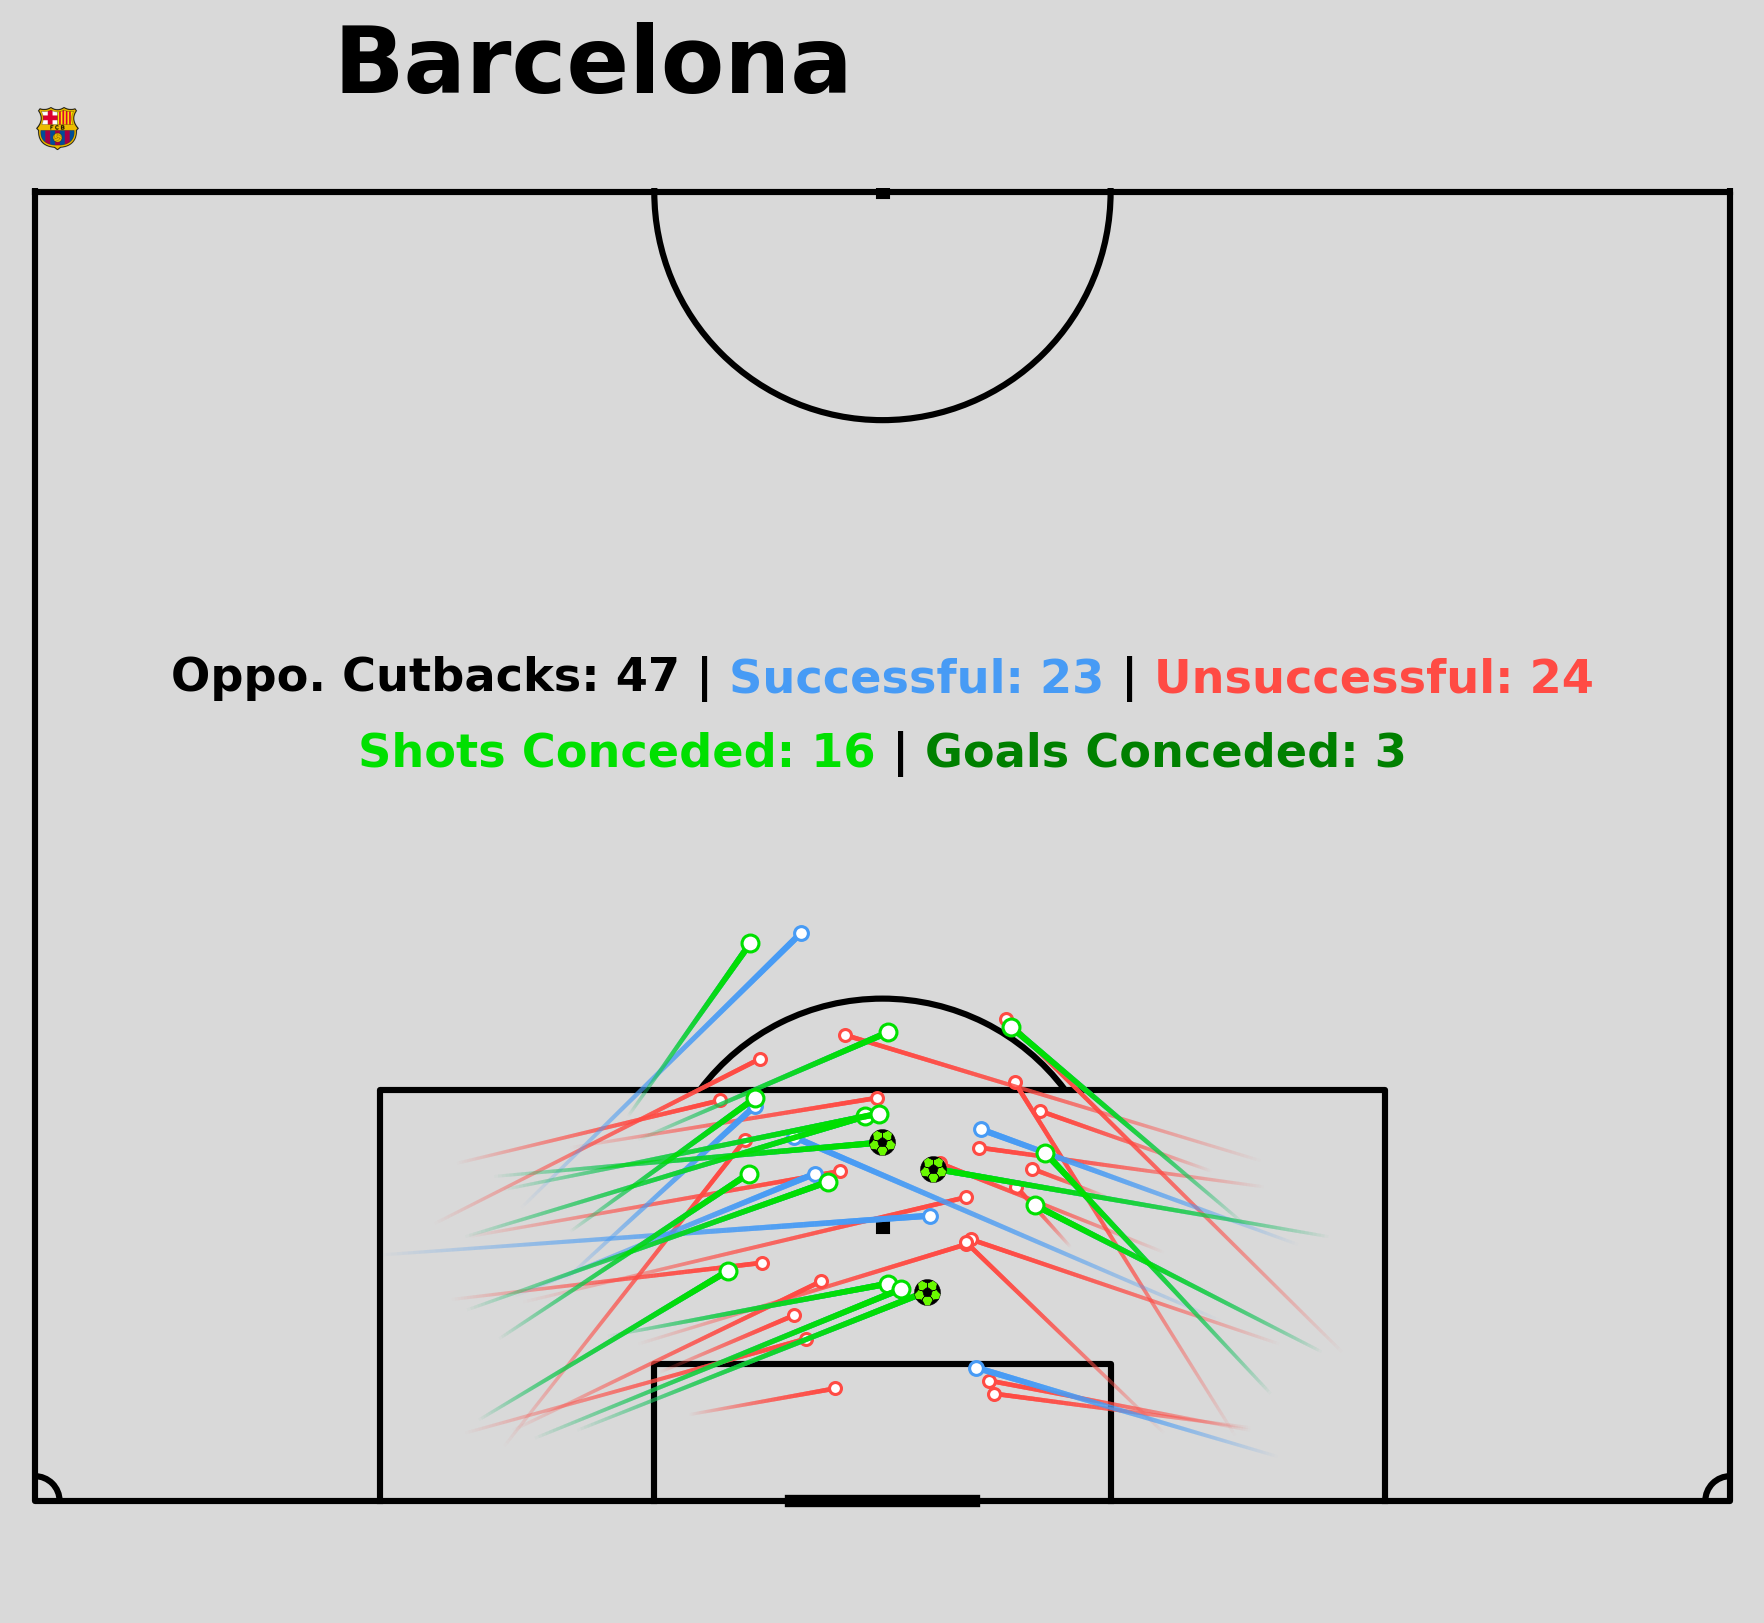

Execution Time: 1.4313156604766846 seconds


In [21]:
# Define the plot_cutback_against function
def plot_cutback_against(ax, team_name):
    df_team = df[(df['oppositionTeamName'] == team_name) & (df['type'] == 'Pass') & (~df['qualifiers'].str.contains('Chipped')) 
                 & (~df['qualifiers'].str.contains('Corner'))]

    # Define the conditions for the half_spaces area
    half_space_cond = ((df_team['x'] >= 88.54) & (df_team['x'] <= 105) & 
                       ((df_team['y'] >= 40.8) & (df_team['y'] <= 54.4) | (df_team['y'] >= 13.6) & (df_team['y'] <= 27.2)) & 
                       (df_team['endY'] >= 27.2) & (df_team['endY'] <= 40.8) & (df_team['endX'] >= 81.67))

    cutback = df_team[half_space_cond]

    pitch = VerticalPitch(pitch_type='uefa', pitch_color='#d9d9d9', line_color='k', spot_type='square', linewidth=2, half=True, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_ylim(52.35)
    ax.set_xlim(-0.5, 68.5)

    succ_cutbacks = unsucc_cutbacks = kp_cutbacks = assist_cutbacks = 0
    succ_cutbacks_players = []
    unsucc_cutbacks_players = []
    kp_cutbacks_players = []
    assist_cutbacks_players = []

    # Loop through cutbacks and categorize them
    for index, row in cutback.iterrows():
        if row['x'] >= row['endX'] + 1:
            if row['outcomeType'] == 'Successful':
                pitch.lines(row['x'], row['y'], row['endX'], row['endY'], lw=2, comet=True, transparent=True, zorder=2, color='#479bf5', ax=ax)
                pitch.scatter(row['endX'], row['endY'], marker='o', s=20, c='w', ec='#479bf5', lw=1, ax=ax, zorder=2)
                succ_cutbacks += 1
                if 'KeyPass' in row['qualifiers']:
                    pitch.lines(row['x'], row['y'], row['endX'], row['endY'], lw=2, comet=True, transparent=True, zorder=3, color='#00e000', ax=ax)
                    pitch.scatter(row['endX'], row['endY'], marker='o', s=30, c='w', ec='#00e000', lw=1, ax=ax, zorder=3)
                    kp_cutbacks += 1
                if 'IntentionalGoalAssist' in row['qualifiers']:
                    pitch.scatter(row['endX'], row['endY'], marker='football', s=75, c='#69f900', ax=ax, linewidths=0.15, zorder=4)
                    assist_cutbacks += 1
            elif row['outcomeType'] == 'Unsuccessful':
                pitch.lines(row['x'], row['y'], row['endX'], row['endY'], lw=1.5, comet=True, transparent=True, zorder=1, color='#ff4b44', ax=ax)
                pitch.scatter(row['endX'], row['endY'], marker='o', s=15, c='w', ec='#ff4b44', lw=1, ax=ax, zorder=1)
                unsucc_cutbacks += 1


    total_cutbacks = succ_cutbacks + unsucc_cutbacks

    ax_text(34, 72, s=f'Oppo. Cutbacks: {total_cutbacks} | <Successful: {succ_cutbacks}> | <Unsuccessful: {unsucc_cutbacks}>', 
            color='k', fontsize=15, fontweight='bold', highlight_textprops=[{"color":"#479bf5"}, {"color":"#ff4b44"}],
            va = "center", ha = "center", ax=ax)
    ax_text(34, 75, s=f'<Shots Conceded: {kp_cutbacks}> | <Goals Conceded: {assist_cutbacks}>', 
            color='k', fontsize=15, fontweight='bold', highlight_textprops=[{"color":"#00e000"}, {"color":"g"}],
            va = "center", ha = "center", ax=ax)

    ax.text(12, 48.5, f'{team_name}', color='k', fontsize=30, fontweight='bold')

    # Take data coordinates and transform them to normalized figure coordinates
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((0, 110.5))
    ax_size = 0.02
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    fotmob_url = f'https://raw.githubusercontent.com/adnaaan433/club_teams_logos/main/{team_name}.png'
    fotmob_url = fotmob_url.replace(' ', '%20')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('off')

    ax.invert_yaxis()
    
    return 

# Measure the execution time
start_time = time.time()
fig, ax = plt.subplots(facecolor='#d9d9d9', figsize=(10,10), dpi=222)
plot_cutback_against(ax, 'Barcelona')
end_time = time.time()
execution_time = end_time - start_time

plt.show()

print(f"Execution Time: {execution_time} seconds")

Execution Time: 31.402802228927612 seconds


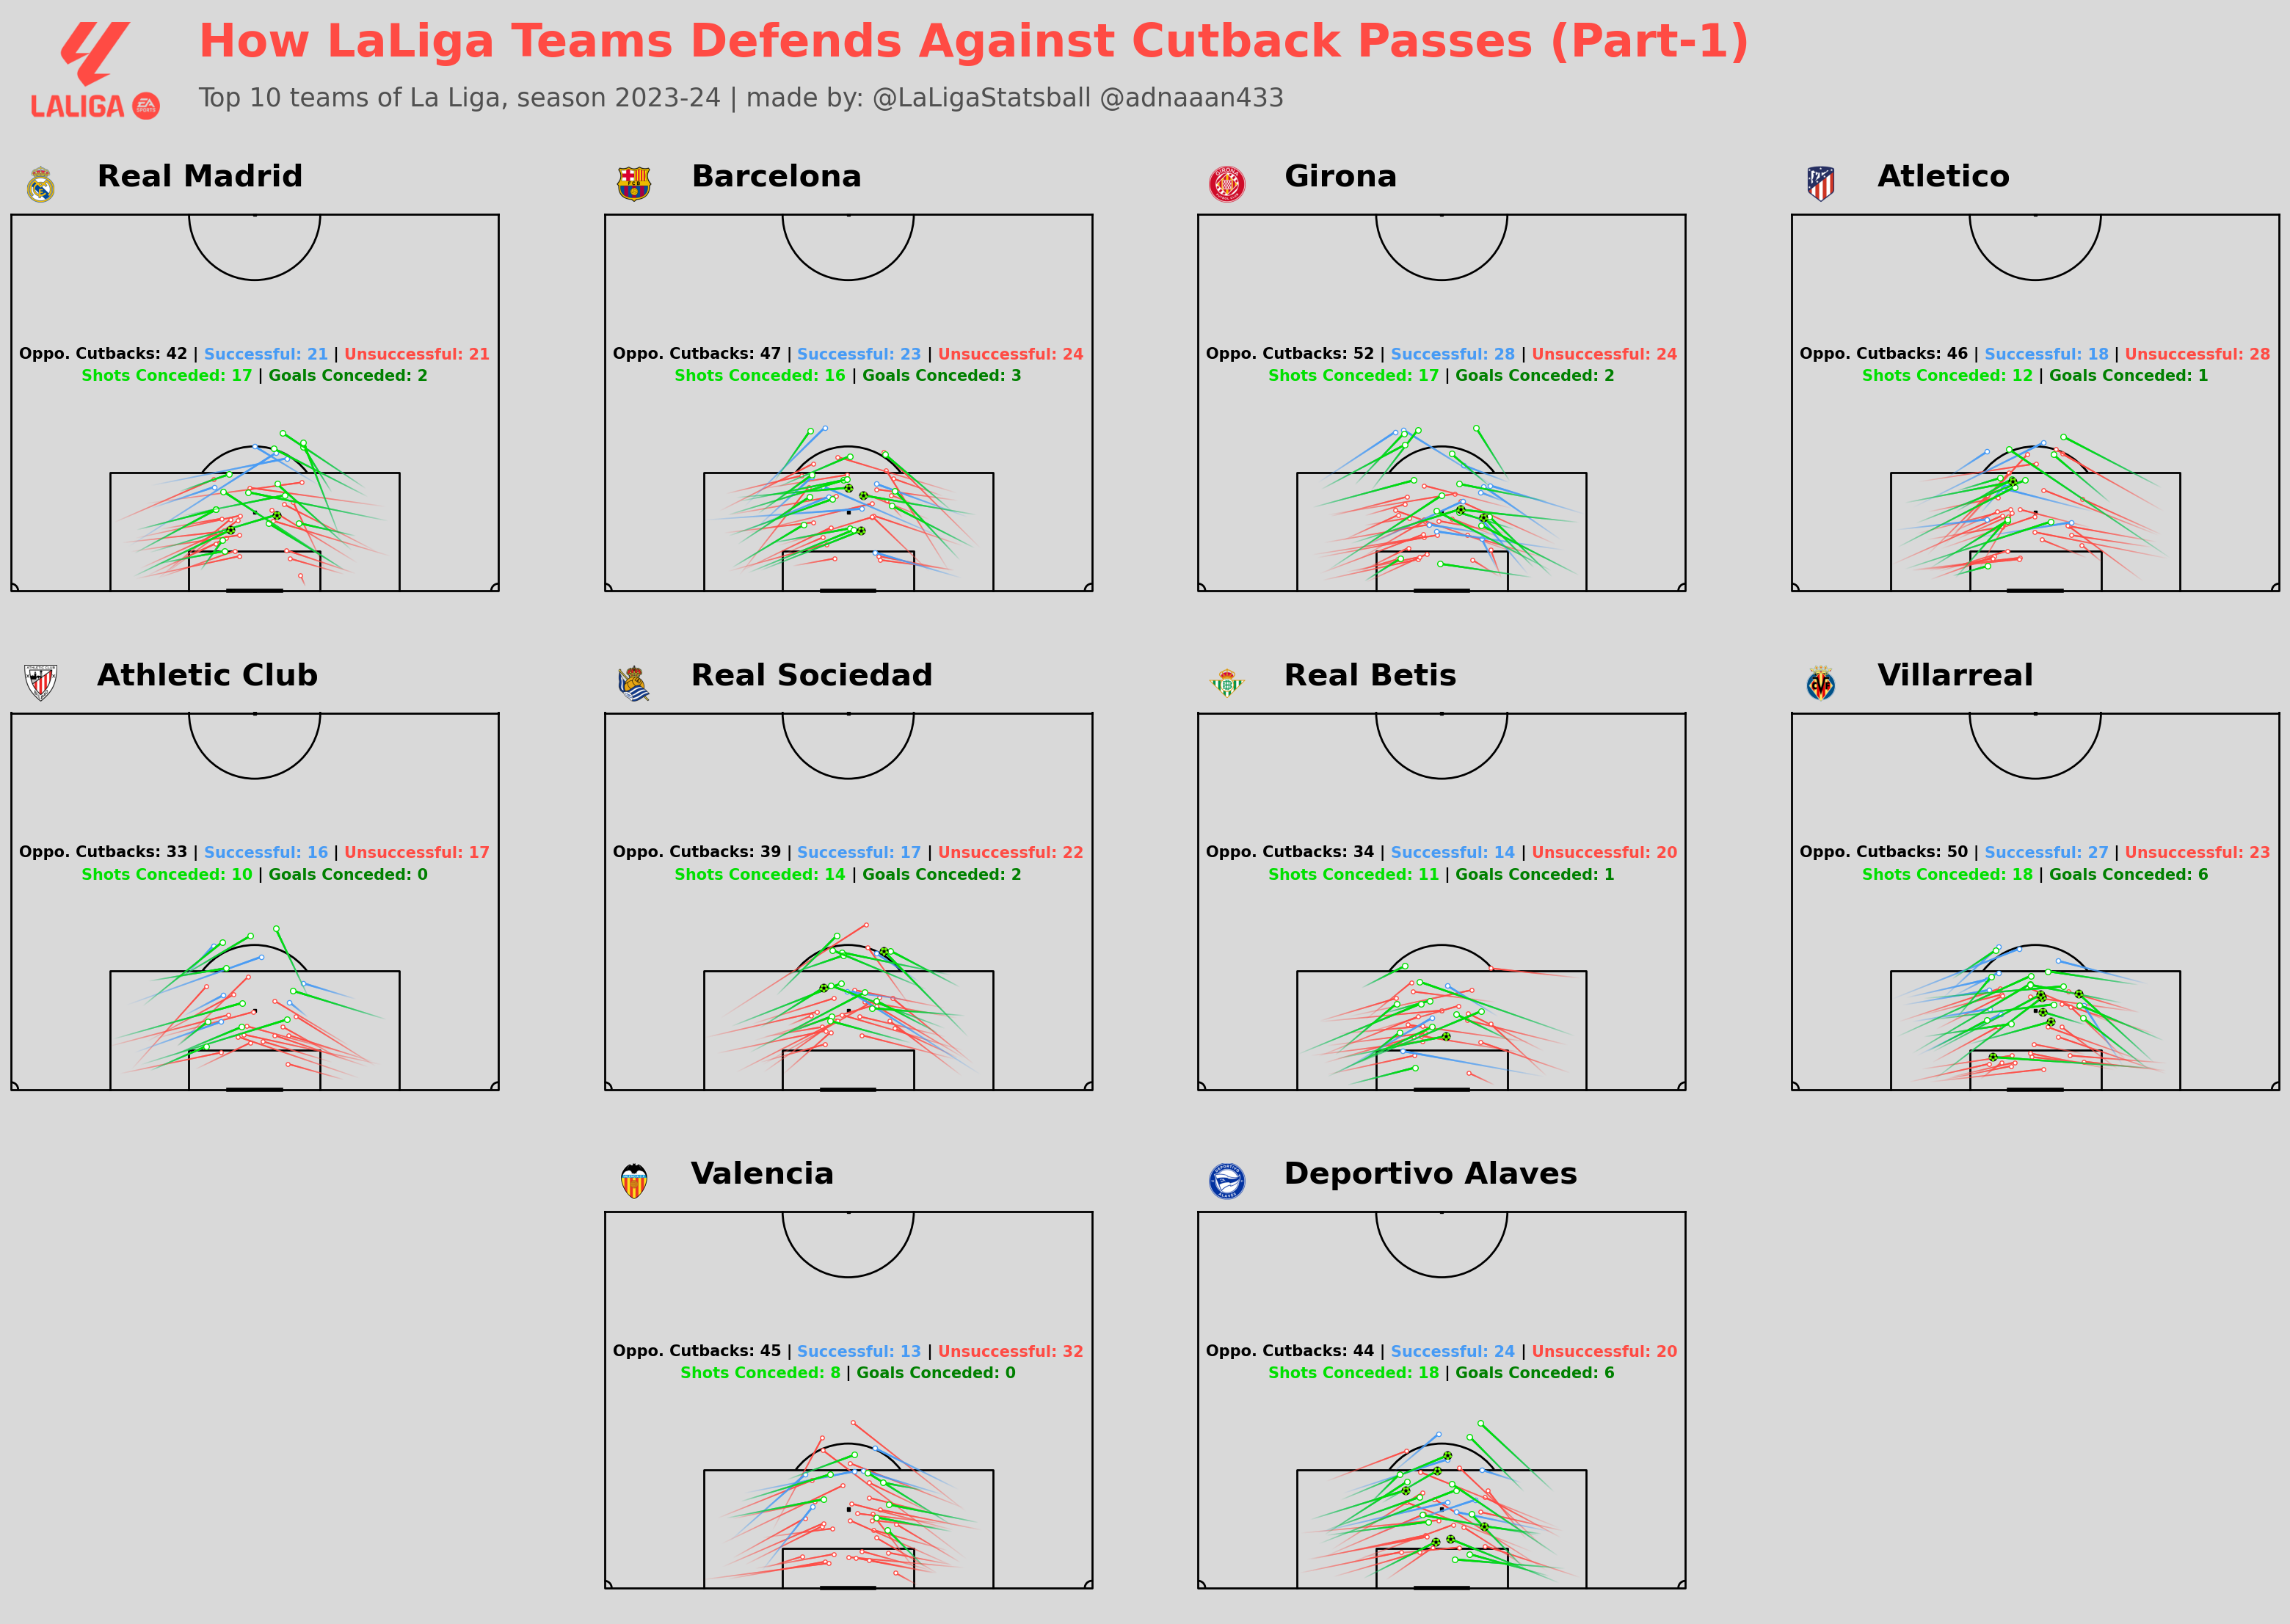

In [22]:
start_time = time.time()
fig, axs = plt.subplots(3, 4, figsize=(40, 25), facecolor='#d9d9d9', dpi=100)
axs = axs.flatten()

# List of team names
team_names = ['Real Madrid', 'Barcelona', 'Girona', 'Atletico', 'Athletic Club', 'Real Sociedad', 'Real Betis', 'Villarreal']

for i, team_name in enumerate(team_names):
    plot_cutback_against(axs[i], team_name)

plot_blank(axs[8])
plot_cutback_against(axs[9], 'Valencia')
plot_cutback_against(axs[10], 'Deportivo Alaves')
plot_blank(axs[11])

fig.text(0.19, 0.97, 'How LaLiga Teams Defends Against Cutback Passes (Part-1)', color='#ff4b44', fontweight='bold', fontsize=45, ha='left', va='center')
fig.text(0.19, 0.94, 'Top 10 teams of La Liga, season 2023-24 | made by: @LaLigaStatsball @adnaaan433', color='#505050', fontsize=25, ha='left', va='center')

image_url = 'https://raw.githubusercontent.com/adnaaan433/league_logos/main/LaLiga.png'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.12, bottom=0.92, width=0.07, height=0.07)



# plt.tight_layout()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time} seconds")

Execution Time: 29.822343111038208 seconds


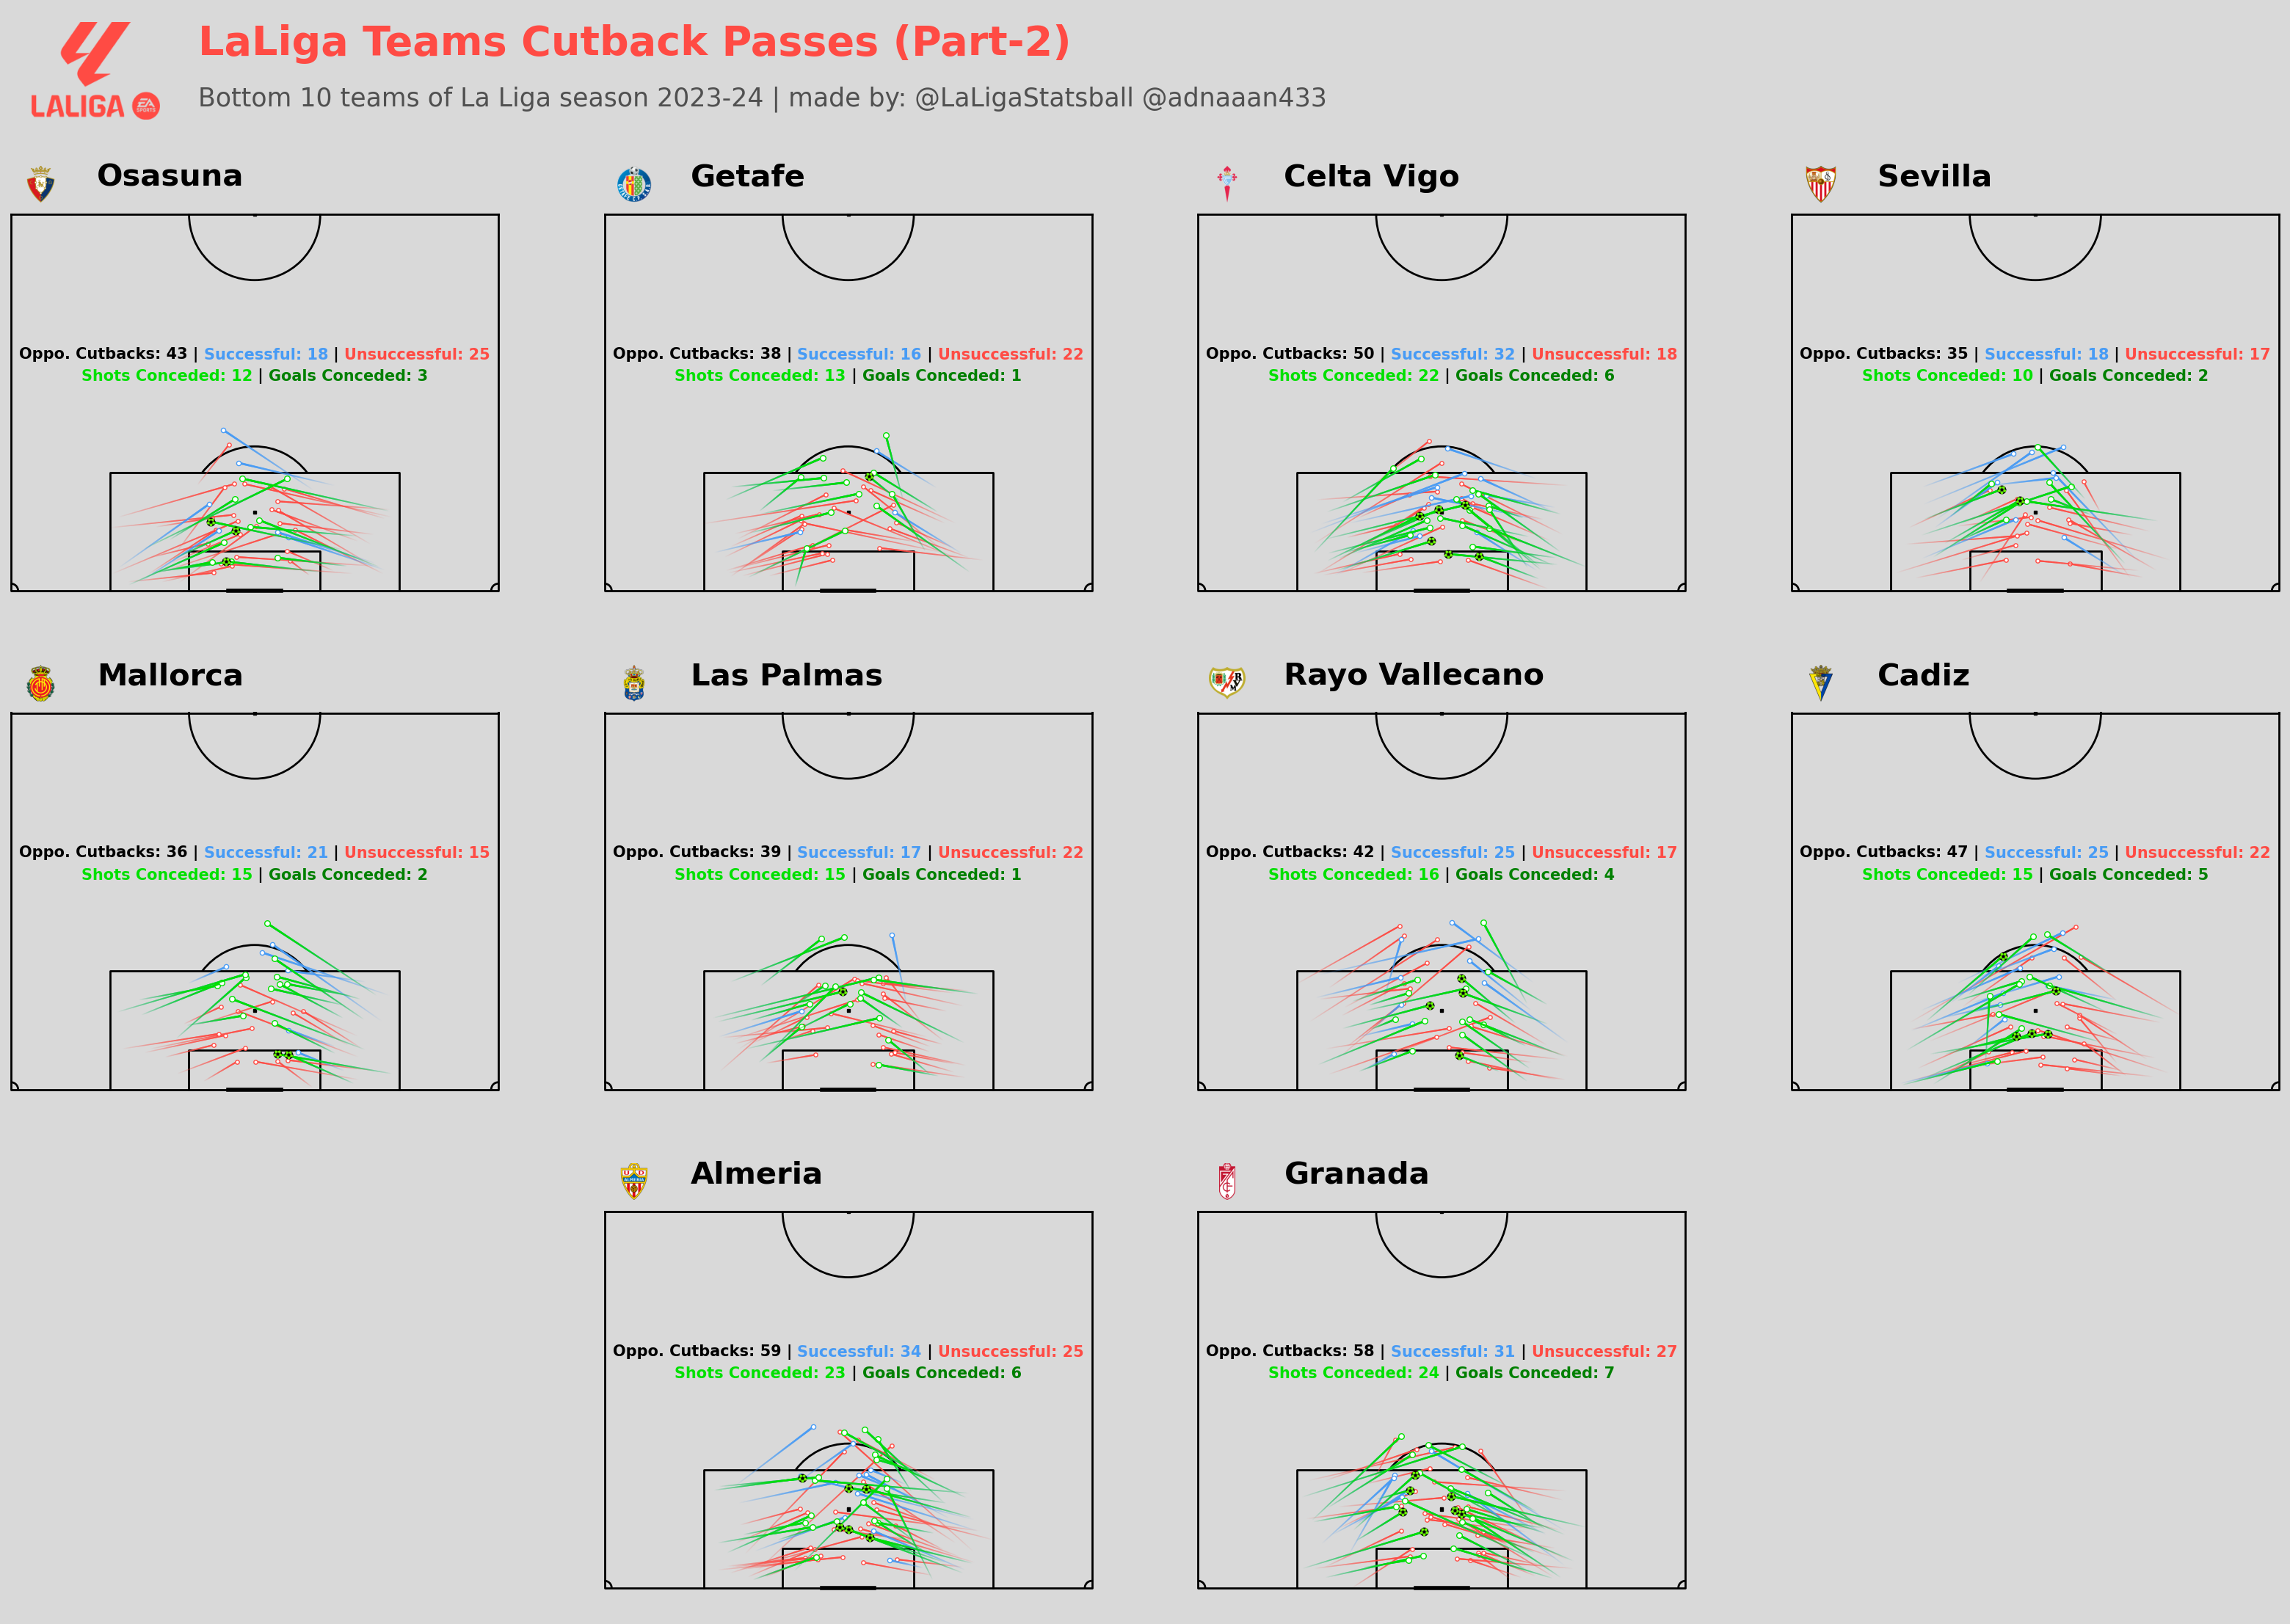

In [24]:
start_time = time.time()
fig, axs = plt.subplots(3, 4, figsize=(40, 25), facecolor='#d9d9d9', dpi=100)
axs = axs.flatten()

# List of team names
team_names = ['Osasuna', 'Getafe', 'Celta Vigo', 'Sevilla', 'Mallorca', 'Las Palmas', 
              'Rayo Vallecano', 'Cadiz']

for i, team_name in enumerate(team_names):
    plot_cutback_against(axs[i], team_name)

plot_blank(axs[8])
plot_cutback_against(axs[9], 'Almeria')
plot_cutback_against(axs[10], 'Granada')
plot_blank(axs[11])

fig.text(0.19, 0.97, 'LaLiga Teams Cutback Passes (Part-2)', color='#ff4b44', fontweight='bold', fontsize=40, ha='left', va='center')
fig.text(0.19, 0.94, 'Bottom 10 teams of La Liga season 2023-24 | made by: @LaLigaStatsball @adnaaan433', color='#505050', fontsize=25, ha='left', va='center')

image_url = 'https://raw.githubusercontent.com/adnaaan433/league_logos/main/LaLiga.png'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.12, bottom=0.92, width=0.07, height=0.07)



# plt.tight_layout()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time} seconds")